<a href="https://www.kaggle.com/code/metegurkan/animal-classification-with-cnn?scriptVersionId=214348190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Within the scope of the project:**

* By designing and testing the CNN model, 10 different animal classes will be distinguished. These classes: collie, dolphin, elephant, fox, moose, rabbit, sheep, squirrel, giant panda and polar bear.
* The performance of the model on images manipulated in different lighting conditions will be tested and the changes caused by this situation will be examined.
* Efforts will be made to reduce the effect of manipulations with techniques such as color constancy algorithms and the performance of the model will be re-evaluated.
* Finally, the results of three different test scenarios will be reported and solution suggestions will be presented.

# #1) Installing Libraries

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

**Warnings**: Used to ignore warning messages in Python. It is especially preferred in cases where you do not want warning messages to fill the outputs.

In [2]:
import warnings 
warnings.filterwarnings("ignore")

# 2) Preparation and Balancing of the Data Set
This code is prepared to select specific classes from the Animals with Attributes 2 dataset and organize them neatly by filtering an equal number of images from each class. This process aims to create a balanced data set between classes and contributes to better performance of deep learning models.

In [3]:
# Paths for the dataset folders
source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"  # Path to the original dataset
target_dir = "FilteredImages"  # Path to save the filtered and balanced dataset

# Classes to be used
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650  # Number of images per class

# Filtering and balancing the dataset
os.makedirs(target_dir, exist_ok=True)
for class_name in selected_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(target_dir, class_name)
    os.makedirs(target_path, exist_ok=True)
    for i, file_name in enumerate(os.listdir(class_path)):
        if i >= images_per_class:
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            cv2.imwrite(os.path.join(target_path, file_name), cv2.imread(full_file_name))
print("Dataset has been prepared and balanced.")


Dataset has been prepared and balanced.


# 3) Dimensioning and Normalization 
In this project, a Python function was written to process images in a folder structure and make them suitable for model training. The function performs the following operations:

**Uploading Images:**

Images for each class in the folder structure are read using cv2.imread.

**Image Sizing:**

Images are scaled to 128x128 pixels with cv2.resize to accommodate the fixed input size of each model.

**Image Normalization:**

Pixel values are moved from the range 0-255 to the range 0-1 (img_resized / 255.0). This process allows the model to learn faster and more stable.
**Tag Assignment:**

The classes to which the images belong are associated with folder names and assigned as labels to each image.
**Data Conversion:**

The processed images and labels are returned as numpy arrays.

In [4]:
# Processing of images (128x128 resizing and normalization)
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

data_dir = target_dir
X, y = load_and_process_images(data_dir)
print(f"Dataset size: {X.shape}")


Dataset size: (6500, 128, 128, 3)


# 4) Separating Data as Training and Test Set
At this stage, the labels of the images were converted into numerical and singular format, and then the data was divided into training and test sets.

In [5]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert labels into numerical format and one-hot encode them
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Transform string labels into numerical labels
y_categorical = to_categorical(y_encoded)  # Convert numerical labels into one-hot encoded format

# Splitting the data (70% training, 30% testing)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
print(f"Training data size: {X_train.shape}, Test data size: {X_test.shape}")


Training data size: (4550, 128, 128, 3), Test data size: (1950, 128, 128, 3)


# 5) Data Augmentation
Data augmentation is a technique used to diversify the training data set in image classification problems. This is important to increase the generalization ability of the model, especially in situations with limited data.

The following data augmentation operations have been implemented with the ImageDataGenerator class:

**Rotation (rotation_range):** 
Images were randomly rotated by up to 20 degrees.

**Width (width_shift_range):** 
Images shifted horizontally by up to 20%.

**Height (height_shift_range):** 
Images shifted vertically by up to 20%.

**Shear (shear_range):** 
The images were cropped at a rate of 0.2.

**Zoom (zoom_range):** 
Images were zoomed in by 20%.

**Mirroring (horizontal_flip):** 
Images were inverted horizontally.

**Fill Mode (fill_mode):** 
The empty spaces created during manipulation were filled with the closest pixel values.

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,            # Randomly apply shear transformations
    zoom_range=0.2,             # Randomly zoom into images by up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after transformations
)

datagen.fit(X_train)  # Apply the augmentations to the training data

# 6) CNN Model
This code creates a Convolutional Neural Network (CNN) model that is used to solve the image classification problem.

In [7]:
# CNNModel
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(128, 128, 3)), # Input is used here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# 7) CNN Model Compilation and Training Process
In this section, the created CNN model was compiled and trained using data augmentation. The training process is designed to solve the classification problem.

In [8]:
# Compile the model
model.compile(
    optimizer='adam', # Optimization algorithm
    loss='categorical_crossentropy', # Loss function
    metrics=['accuracy'] # Evaluation metric
)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Training and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

# steps_per_epoch and validation_steps calculation
steps_per_epoch = len(X_train) // 32
validation_steps = len(X_test) // 32

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 515ms/step - accuracy: 0.2328 - loss: 3.8625 - val_accuracy: 0.4031 - val_loss: 1.7198
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.4375 - loss: 1.4854 - val_accuracy: 0.1667 - val_loss: 1.7684
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.4513 - loss: 1.6346 - val_accuracy: 0.4870 - val_loss: 1.5391
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.5312 - loss: 1.2744 - val_accuracy: 0.3333 - val_loss: 1.6767
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 514ms/step - accuracy: 0.4999 - loss: 1.4657 - val_accuracy: 0.5031 - val_loss: 1.4812
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.4375 - loss: 1.7838 - val_accuracy: 0.6000 - val_loss: 1.2997
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 518ms/step - accuracy: 0.5416 - loss: 1.3511 - val_accuracy: 0.5349 - val_loss: 1.4039
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.5000 - loss: 1.481

# 8)Training the Model and Performance Analysis
In this section, the CNN model was trained and the accuracy values ​​obtained by the model during the training process were visualized.


Epoch 1/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - accuracy: 0.6075 - loss: 1.1347 - val_accuracy: 0.6174 - val_loss: 1.2013
Epoch 2/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 479ms/step - accuracy: 0.6272 - loss: 1.0709 - val_accuracy: 0.6174 - val_loss: 1.2513


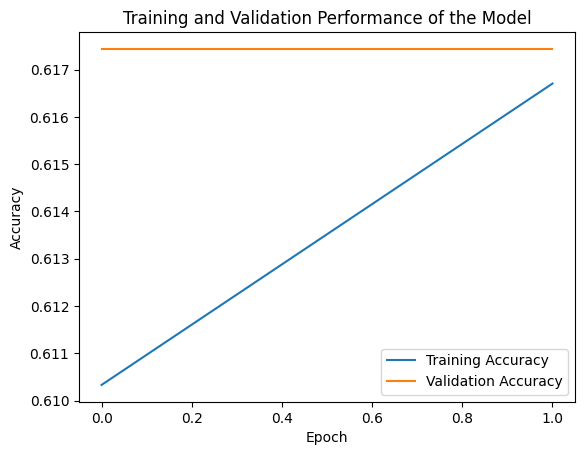

In [9]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),  # Use augmented training data
                    validation_data=(X_test, y_test),               # Use test data for validation
                    epochs=2)                                      # Train for 15 epochs

# Plot training and validation results
plt.plot(history.history['accuracy'], label='Training Accuracy')     # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.legend()                                                         # Add a legend
plt.title("Training and Validation Performance of the Model")        # Add a title
plt.xlabel("Epoch")                                                  # Label the x-axis
plt.ylabel("Accuracy")                                               # Label the y-axis
plt.show()                                                           # Display the plot

# 9) Image Manipulation and Evaluation of Model Performance
In this section, the images in the test data set were manipulated and the performance of the model on this manipulated data was measured. Image manipulation was accomplished by brightness enhancement.

In [10]:
# Image Manipulation (e.g., increasing brightness)
def manipulate_images(images):
    manipulated_images = []
    for img in images:
        # Increase brightness: alpha scales the pixel values, beta adds a constant brightness
        manipulated = cv2.convertScaleAbs(img, alpha=1.5, beta=30)
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

# Apply manipulation to the test dataset
X_test_manipulated = manipulate_images(X_test)

# Evaluate the model on the manipulated dataset
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipulated Test Accuracy: {manipulated_accuracy * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.0969 - loss: 256.3949
Manipulated Test Accuracy: 9.69%


# 10) Testing the Model with a Manipulated Test Set
In this step, the performance of the model was re-evaluated using the test set in which we previously manipulated the light conditions. The manipulation was done by changing properties of the images, such as brightness and contrast, to measure how robust the model was to changing lighting conditions.

In [11]:
# Testing on a manipulated test set
test_loss, test_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipulated Test Set Accurate: {test_accuracy}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.0969 - loss: 256.3949
Manipulated Test Set Accurate: 0.09692307561635971


# 11) Implementing and Testing Color Constancy Algorithm
**Comparison of Model Accuracy Results**

At this stage, the performances of the model on different data sets were compared:

In [12]:
# Gray World algorithm
def gray_world(images):
    wb_images = []
    for img in images:
        avg_b = np.mean(img[:, :, 0])
        avg_g = np.mean(img[:, :, 1])
        avg_r = np.mean(img[:, :, 2])
        avg_gray = (avg_b + avg_g + avg_r) / 3
        img[:, :, 0] = img[:, :, 0] * (avg_gray / avg_b)
        img[:, :, 1] = img[:, :, 1] * (avg_gray / avg_g)
        img[:, :, 2] = img[:, :, 2] * (avg_gray / avg_r)
        wb_images.append(img)
    return np.array(wb_images)

# Applying the Gray World algorithm to manipulated test data
X_test_corrected = gray_world(X_test_manipulated)

# Evaluating the model with a test set with color constancy applied
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Test Accuracy with Color Fixation Applied: {corrected_accuracy * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.0969 - loss: 259.8825
Test Accuracy with Color Fixation Applied: 9.69%


# Model Testing Results
**General Comment:** 

It can be said that the model is very sensitive, especially to changes in light conditions, but adjustments such as color constancy are not sufficient to increase accuracy.
This analysis reveals how sensitive the model is to environmental factors and how it performs against manipulations.

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Color Fixed Test Set Accuracy: {test_accuracy}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.0969 - loss: 259.8825
Color Fixed Test Set Accuracy: 0.09692307561635971


In [14]:
# Calculate accuracy on the original test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)  # Suppress detailed output
print(f"Original Test Set Accuracy: {test_accuracy * 100:.2f}%")

# Calculate accuracy on the manipulated test set
X_test_manipulated = manipulate_images(X_test)  # Apply image manipulation (e.g., brightness increase)
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test, verbose=0)
print(f"Manipulated Test Set Accuracy: {manipulated_accuracy * 100:.2f}%")

# Calculate accuracy on the test set with color constancy applied
X_test_corrected = gray_world(X_test_manipulated)  # Apply color constancy using the Gray World algorithm
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test, verbose=0)
print(f"Color Corrected Test Set Accuracy: {corrected_accuracy * 100:.2f}%")

Original Test Set Accuracy: 61.74%
Manipulated Test Set Accuracy: 9.69%
Color Corrected Test Set Accuracy: 9.69%


In [15]:
# Comparison of test results
print("Results:")
print(f"Original Test Set Accuracy: {test_accuracy * 100:.2f}%")
print(f"Manipulated Test Set Accuracy: {manipulated_accuracy * 100:.2f}%")
print(f"Color Fixed Test Set Accuracy: {corrected_accuracy * 100:.2f}%")

Results:
Original Test Set Accuracy: 61.74%
Manipulated Test Set Accuracy: 9.69%
Color Fixed Test Set Accuracy: 9.69%
